In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

import prettytable
import time
import sys
sys.setrecursionlimit(18000)

from PIL import Image
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
from torch.utils.data import random_split

from model501 import FixCapsNet
from images_show import ImageShow

In [3]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"
best_acc= 0.
#defined 
try:
    print(len(test_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list=train_loss_list,
                train_acc_list=train_acc_list,
                test_loss_list=test_loss_list,
                test_acc_list=test_acc_list,
                test_auc_list=test_auc_list,
                val_loss_list=val_loss_list,
                val_acc_list=val_acc_list,
                )

In [4]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((308,308)),
                               transforms.CenterCrop((299, 299)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
    }

In [5]:
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
image_path = os.path.abspath(os.path.join(root_path,"skin_lesion"))
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
test_dataset = datasets.ImageFolder(root=os.path.join(image_path,"test"),
                                      transform=data_transform["val"])
train_num = len(train_dataset)
test_num = len(test_dataset)

img_sample = Image.open(test_dataset.imgs[1][0])
n_channels = np.array(img_sample).shape[2]#(H,W,C)

data_list = train_dataset.class_to_idx #
cla_dict = dict((val, key) for key, val in data_list.items())
n_classes  = len(data_list)
print(f'Using {n_classes} types.')

# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open(f'{img_title}.json', 'w') as json_file:#class_indices
    json_file.write(json_str)

BatchSize = 188
T_size = 31
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 8]) 
print(f'Using {nw} dataloader workers every process.')
pin_memory = True
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BatchSize,pin_memory=pin_memory,
                                           shuffle=True, num_workers=nw)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=T_size,pin_memory=pin_memory,
                                          shuffle=False, num_workers=nw)

print("using {} images for training, {} images for validation.".format(train_num, test_num))

Using 7 types.
Using 8 dataloader workers every process.
using 51699 images for training, 828 images for validation.


In [6]:
# Create capsule network.
conv_outputs = 128 #128_Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6
output_unit_size = 16
img_size = 299
network = FixCapsNet(conv_inputs= n_channels,
                     conv_outputs=conv_outputs,
                     num_primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     output_unit_size=output_unit_size,
                     num_classes=n_classes,
                     init_weights=True)

network = network.to(device)
summary(network,(n_channels,img_size,img_size))
# network

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 135, 135]           2,886
            Conv2d-2        [-1, 128, 135, 135]             512
       BatchNorm2d-3        [-1, 128, 135, 135]             256
              ReLU-4        [-1, 128, 135, 135]               0
FractionalMaxPool2d-5          [-1, 128, 20, 20]               0
            Conv2d-6          [-1, 128, 20, 20]          16,384
       BatchNorm2d-7          [-1, 128, 20, 20]             256
         Hardswish-8          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
             ReLU-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [7]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

In [8]:
def confusion_matrix(evl_result):

    plt.style.use("seaborn")#classic
    plt.yticks(range(n_classes),cla_dict.values())
    plt.xticks(range(n_classes),cla_dict.values())    
    plt.title("Confusion Matrix")
    plt.imshow(evl_result,cmap=plt.cm.Greens)
    for i in range(len(evl_result)):
        for j in range(len(evl_result[i])):
            plt.text(j,i,int(evl_result[i][j]))

    plt.colorbar()
    plt.savefig(f"./tmp/{img_title}/{suf}/Confusion Matrix.png",dpi=128)

In [9]:
def self_scores(opt="scores"):
    result_table = prettytable.PrettyTable()
    result_table.field_names = ['Type','Precision', 'Recall', 'F1','Accuracy']    
    accuracy = float(torch.sum(evl_result.diagonal())/torch.sum(evl_result))

    for i in range(n_classes):
        pre = float(evl_result[i][i] / torch.sum(evl_result,0)[i])#
        recal = float(evl_result[i][i] / torch.sum(evl_result,1)[i])#torch.sum(result_table[i])
        F1 = pre * recal * 2 / (pre + recal + 1e-7)
        result_table.add_row([cla_dict[i], round(pre, 4), round(recal, 3), round(F1, 3)," "])

    result_table.add_row(["Total:", " ", " ", " ",round(accuracy,4)])
    print(result_table)

In [10]:
# Converts batches of class indices to classes of one-hot vectors.
def to_one_hot(x, length):
    batch_size = x.size(0)
    x_one_hot = torch.zeros(batch_size, length)
    for i in range(batch_size):
        x_one_hot[i, x[i]] = 1.0
    return x_one_hot

In [11]:
def train(epoch):
    network.train()
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    print(f'Epoch: [{epoch}] {img_title} ==> Training ...')
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        
        # target = torch.as_tensor(target, dtype=torch.int64)#for windows

        batch_idx += 1
        target_indices = target
        target_one_hot = to_one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
        optimizer.zero_grad()
        output = network(data)

        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        
        loss = network.loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % print_step == 0:
            print("[{}/{}] Loss{:.5f}, ACC:{:.5f}%".format(batch_idx,len(train_loader),
                                                           loss,
                                                           r_pre/(batch_idx*BatchSize),))
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)    
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)
    
    print(f'Train_Loss: {epoch_loss},ACC:{round(float(epoch_acc),3)}%')   
    scheduler.step()

In [12]:
def test():
    network.eval()
    global best_acc,evl_result,evl_tmp_result,net_parameters
    cor_loss,correct,tmp_size, Acc=  0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    steps_num = len(test_loader)#len(test_loader) * T_size
    tmp_size = T_size
    print(f'\033[66m{img_title} ==> testing ...\033[0m')
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):

            batch_idx +=1
            target_indices = target
            #torch.Size([128, 7]),tensor([[0., 0., 0., 0., 0., 1., 0.],...,[0., 0., 0., 0., 0., 1., 0.]])
            target_one_hot = to_one_hot(target_indices, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output = network(data)#torch.Size([batch_size, 7, 16, 1])        
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]  
               
            if batch_idx % steps_num == 0 and test_num % T_size != 0:
                tmp_size = test_num % T_size

            for i in range(tmp_size):
                pred_y = pred.numpy()         
                evl_tmp_result[target_indices[i]][pred[i]] +=1 
    
    diag_sum = torch.sum(evl_tmp_result.diagonal())
    all_sum = torch.sum(evl_tmp_result)   
    accuracy = 100. * float(torch.div(diag_sum,all_sum)) 
    test_acc_list.append(accuracy)
    
    print(f"Test_Acc:\033[1;32m{round(float(accuracy),3)}%\033[0m")

    if accuracy > best_acc:
        best_acc = accuracy
        evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
        torch.save(network.state_dict(), save_PATH)
        torch.save(evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pt')
        
    print(f'Best_ACC[\033[1;32m{round(float(best_acc),3)}%\033[0m]')

In [13]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: ./tmp/{img_title}/{suf}')
else:
#     !mkdir -p ./tmp/{img_title}/{suf} #linux
    !md E:\Jupyter\woodman\Caps\FixCaps\tmp\{img_title}\{suf} #windows
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
print(save_PATH)

suf:0502_000407
./tmp/HAM10000/0502_000407/best_HAM10000_0502_000407.pth


子目录或文件 #windows 已经存在。
处理: #windows 时出错。


In [14]:
num_epochs = 150
# network.load_state_dict(torch.load(save_PATH))

In [15]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()
print('Finished Training')

Epoch: [1] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.38900, ACC:0.31833%
[274/275] Loss0.38110, ACC:0.37246%
Train_Loss: 0.4051975733583624,ACC:0.373%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:78.261%
Best_ACC[78.261%]
Epoch: [2] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.32512, ACC:0.45640%
[274/275] Loss0.33855, ACC:0.46148%
Train_Loss: 0.3492355242642489,ACC:0.462%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:61.594%
Best_ACC[78.261%]
Epoch: [3] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.32908, ACC:0.48874%
[274/275] Loss0.32721, ACC:0.49227%
Train_Loss: 0.33107150782238354,ACC:0.492%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:64.734%
Best_ACC[78.261%]
Epoch: [4] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.30874, ACC:0.51273%
[274/275] Loss0.33111, ACC:0.51349%
Train_Loss: 0.3166305586424741,ACC:0.513%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:81.159%
Best_ACC[81.159%]
Epoch: [5] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.32146, ACC:0.52873%
[274/275] Loss0.29695, ACC:0.53232%
Train_Loss: 0.3061523549123244,ACC:0.532%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:82.367%
Best_ACC[82.367%]
Epoch: [6] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.30214, ACC:0.53351%
[274/275] Loss0.33160, ACC:0.53469%
Train_Loss: 0.3044995746829293,ACC:0.535%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.816%
Best_ACC[83.816%]
Epoch: [7] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.28870, ACC:0.54158%
[274/275] Loss0.30168, ACC:0.54020%
Train_Loss: 0.3020496980710463,ACC:0.54%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:80.072%
Best_ACC[83.816%]
Epoch: [8] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.27331, ACC:0.53541%
[274/275] Loss0.30311, ACC:0.53840%
Train_Loss: 0.30260888088833204,ACC:0.539%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:78.382%
Best_ACC[83.816%]
Epoch: [9] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.29996, ACC:0.54636%
[274/275] Loss0.27910, ACC:0.55195%
Train_Loss: 0.298932567726482,ACC:0.552%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:81.763%
Best_ACC[83.816%]
Epoch: [10] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.28199, ACC:0.55921%
[274/275] Loss0.28293, ACC:0.56554%
Train_Loss: 0.2896763958714225,ACC:0.566%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.575%
Best_ACC[83.816%]
Epoch: [11] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.27987, ACC:0.58196%
[274/275] Loss0.28665, ACC:0.58309%
Train_Loss: 0.28041763349012894,ACC:0.583%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:62.319%
Best_ACC[83.816%]
Epoch: [12] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.26719, ACC:0.59376%
[274/275] Loss0.28177, ACC:0.59598%
Train_Loss: 0.27273339618336073,ACC:0.596%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:62.44%
Best_ACC[83.816%]
Epoch: [13] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.28019, ACC:0.61046%
[274/275] Loss0.25284, ACC:0.61215%
Train_Loss: 0.26338164773854345,ACC:0.612%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:80.918%
Best_ACC[83.816%]
Epoch: [14] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.26984, ACC:0.62230%
[274/275] Loss0.26943, ACC:0.62566%
Train_Loss: 0.25493517436764457,ACC:0.626%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:78.382%
Best_ACC[83.816%]
Epoch: [15] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22863, ACC:0.63476%
[274/275] Loss0.24742, ACC:0.63377%
Train_Loss: 0.24874085783958436,ACC:0.634%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:81.28%
Best_ACC[83.816%]
Epoch: [16] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.24876, ACC:0.63224%
[274/275] Loss0.26162, ACC:0.63665%
Train_Loss: 0.24742356430400503,ACC:0.637%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:81.401%
Best_ACC[83.816%]
Epoch: [17] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.25286, ACC:0.63197%
[274/275] Loss0.25643, ACC:0.63432%
Train_Loss: 0.24806237166578118,ACC:0.634%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:73.671%
Best_ACC[83.816%]
Epoch: [18] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.24152, ACC:0.63546%
[274/275] Loss0.23352, ACC:0.63391%
Train_Loss: 0.25108244023539805,ACC:0.634%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:38.889%
Best_ACC[83.816%]
Epoch: [19] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.26742, ACC:0.63096%
[274/275] Loss0.25779, ACC:0.63086%
Train_Loss: 0.2533131429823962,ACC:0.631%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.145%
Best_ACC[85.145%]
Epoch: [20] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.25928, ACC:0.62230%
[274/275] Loss0.27245, ACC:0.62601%
Train_Loss: 0.256608796173876,ACC:0.626%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:72.585%
Best_ACC[85.145%]
Epoch: [21] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.24171, ACC:0.62715%
[274/275] Loss0.25429, ACC:0.62828%
Train_Loss: 0.2534500502998179,ACC:0.628%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:65.7%
Best_ACC[85.145%]
Epoch: [22] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.24812, ACC:0.63709%
[274/275] Loss0.25978, ACC:0.63645%
Train_Loss: 0.2501041978055781,ACC:0.636%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:31.884%
Best_ACC[85.145%]
Epoch: [23] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.26963, ACC:0.65262%
[274/275] Loss0.25303, ACC:0.64800%
Train_Loss: 0.24221336267211221,ACC:0.648%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:15.459%
Best_ACC[85.145%]
Epoch: [24] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.24155, ACC:0.65775%
[274/275] Loss0.23571, ACC:0.65752%
Train_Loss: 0.23639845403757961,ACC:0.657%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:62.198%
Best_ACC[85.145%]
Epoch: [25] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.24451, ACC:0.66392%
[274/275] Loss0.22323, ACC:0.66431%
Train_Loss: 0.23224358336492018,ACC:0.664%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.145%
Best_ACC[85.145%]
Epoch: [26] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22419, ACC:0.66715%
[274/275] Loss0.20657, ACC:0.66798%
Train_Loss: 0.22940539235418492,ACC:0.668%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:76.208%
Best_ACC[85.145%]
Epoch: [27] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20958, ACC:0.66540%
[274/275] Loss0.24183, ACC:0.66746%
Train_Loss: 0.23082742149179633,ACC:0.668%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:76.691%
Best_ACC[85.145%]
Epoch: [28] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.24890, ACC:0.66676%
[274/275] Loss0.23180, ACC:0.66485%
Train_Loss: 0.23322895456444134,ACC:0.665%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.164%
Best_ACC[88.164%]
Epoch: [29] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20955, ACC:0.65635%
[274/275] Loss0.23849, ACC:0.65501%
Train_Loss: 0.2393397432565689,ACC:0.655%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.406%
Best_ACC[88.406%]
Epoch: [30] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21558, ACC:0.64804%
[274/275] Loss0.22655, ACC:0.64991%
Train_Loss: 0.2418495763431896,ACC:0.65%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:61.715%
Best_ACC[88.406%]
Epoch: [31] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.23822, ACC:0.65651%
[274/275] Loss0.22170, ACC:0.65492%
Train_Loss: 0.23971706953915684,ACC:0.655%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:63.768%
Best_ACC[88.406%]
Epoch: [32] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22603, ACC:0.65899%
[274/275] Loss0.24489, ACC:0.65825%
Train_Loss: 0.23725209301168268,ACC:0.658%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:44.686%
Best_ACC[88.406%]
Epoch: [33] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21647, ACC:0.66773%
[274/275] Loss0.21764, ACC:0.66678%
Train_Loss: 0.23214637230743063,ACC:0.667%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:83.333%
Best_ACC[88.406%]
Epoch: [34] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21767, ACC:0.67398%
[274/275] Loss0.23195, ACC:0.67782%
Train_Loss: 0.22598366704854098,ACC:0.678%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.87%
Best_ACC[88.406%]
Epoch: [35] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20344, ACC:0.68279%
[274/275] Loss0.22853, ACC:0.68528%
Train_Loss: 0.2213291408257051,ACC:0.685%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:67.15%
Best_ACC[88.406%]
Epoch: [36] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22910, ACC:0.68640%
[274/275] Loss0.22164, ACC:0.68656%
Train_Loss: 0.22119017140431838,ACC:0.687%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:77.899%
Best_ACC[88.406%]
Epoch: [37] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22164, ACC:0.68687%
[274/275] Loss0.21516, ACC:0.68372%
Train_Loss: 0.22123075691136446,ACC:0.684%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.043%
Best_ACC[88.406%]
Epoch: [38] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22758, ACC:0.68050%
[274/275] Loss0.19307, ACC:0.68023%
Train_Loss: 0.2241890034350482,ACC:0.68%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:60.87%
Best_ACC[88.406%]
Epoch: [39] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20466, ACC:0.67611%
[274/275] Loss0.23395, ACC:0.67522%
Train_Loss: 0.2285563404451717,ACC:0.675%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.541%
Best_ACC[88.406%]
Epoch: [40] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.24090, ACC:0.67083%
[274/275] Loss0.22998, ACC:0.66940%
Train_Loss: 0.23167976569045673,ACC:0.669%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:63.647%
Best_ACC[88.406%]
Epoch: [41] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20995, ACC:0.66874%
[274/275] Loss0.26133, ACC:0.66924%
Train_Loss: 0.2312473787502809,ACC:0.669%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:72.101%
Best_ACC[88.406%]
Epoch: [42] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22600, ACC:0.66777%
[274/275] Loss0.24544, ACC:0.67043%
Train_Loss: 0.23020711026408455,ACC:0.671%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.58%
Best_ACC[90.58%]
Epoch: [43] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21920, ACC:0.68143%
[274/275] Loss0.24202, ACC:0.68136%
Train_Loss: 0.22450107319788498,ACC:0.681%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.802%
Best_ACC[90.58%]
Epoch: [44] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21972, ACC:0.69370%
[274/275] Loss0.18644, ACC:0.69434%
Train_Loss: 0.21787877868522298,ACC:0.694%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.097%
Best_ACC[90.58%]
Epoch: [45] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21932, ACC:0.69463%
[274/275] Loss0.22568, ACC:0.69696%
Train_Loss: 0.21444884500720285,ACC:0.697%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.184%
Best_ACC[91.184%]
Epoch: [46] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20614, ACC:0.69984%
[274/275] Loss0.20042, ACC:0.69910%
Train_Loss: 0.21347852116281335,ACC:0.699%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.787%
Best_ACC[91.787%]
Epoch: [47] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20238, ACC:0.70085%
[274/275] Loss0.19995, ACC:0.69914%
Train_Loss: 0.21364539623260498,ACC:0.699%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.271%
Best_ACC[92.271%]
Epoch: [48] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21920, ACC:0.69199%
[274/275] Loss0.20258, ACC:0.69469%
Train_Loss: 0.2162558383291418,ACC:0.695%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.749%
Best_ACC[92.271%]
Epoch: [49] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.23382, ACC:0.68275%
[274/275] Loss0.22020, ACC:0.68343%
Train_Loss: 0.22355421949516643,ACC:0.683%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:35.749%
Best_ACC[92.271%]
Epoch: [50] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21840, ACC:0.68147%
[274/275] Loss0.20355, ACC:0.68105%
Train_Loss: 0.22518647508187728,ACC:0.681%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.217%
Best_ACC[92.271%]
Epoch: [51] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22669, ACC:0.68454%
[274/275] Loss0.23877, ACC:0.68306%
Train_Loss: 0.22434652496467938,ACC:0.683%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.628%
Best_ACC[92.271%]
Epoch: [52] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21896, ACC:0.68687%
[274/275] Loss0.21630, ACC:0.68629%
Train_Loss: 0.22278961566361513,ACC:0.686%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.01%
Best_ACC[92.271%]
Epoch: [53] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21845, ACC:0.68714%
[274/275] Loss0.25481, ACC:0.68949%
Train_Loss: 0.2198174248500304,ACC:0.689%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.058%
Best_ACC[92.271%]
Epoch: [54] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20793, ACC:0.70116%
[274/275] Loss0.22680, ACC:0.69986%
Train_Loss: 0.2129684245044535,ACC:0.7%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:79.589%
Best_ACC[92.271%]
Epoch: [55] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22214, ACC:0.70853%
[274/275] Loss0.19293, ACC:0.70822%
Train_Loss: 0.20878601025451313,ACC:0.708%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.271%
Best_ACC[92.271%]
Epoch: [56] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20519, ACC:0.70838%
[274/275] Loss0.17697, ACC:0.70867%
Train_Loss: 0.2067682668837634,ACC:0.709%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.995%
Best_ACC[92.995%]
Epoch: [57] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21402, ACC:0.71292%
[274/275] Loss0.20999, ACC:0.71288%
Train_Loss: 0.2078528732061386,ACC:0.713%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.184%
Best_ACC[92.995%]
Epoch: [58] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.25392, ACC:0.70224%
[274/275] Loss0.21272, ACC:0.70224%
Train_Loss: 0.2123010404543443,ACC:0.702%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.976%
Best_ACC[92.995%]
Epoch: [59] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22568, ACC:0.69102%
[274/275] Loss0.21000, ACC:0.69461%
Train_Loss: 0.21697722429578956,ACC:0.694%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.13%
Best_ACC[92.995%]
Epoch: [60] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.23606, ACC:0.69005%
[274/275] Loss0.21712, ACC:0.69071%
Train_Loss: 0.21931094911965457,ACC:0.691%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:56.28%
Best_ACC[92.995%]
Epoch: [61] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22162, ACC:0.69397%
[274/275] Loss0.23058, ACC:0.68949%
Train_Loss: 0.2205604178797115,ACC:0.689%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:88.285%
Best_ACC[92.995%]
Epoch: [62] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22005, ACC:0.69518%
[274/275] Loss0.22245, ACC:0.69460%
Train_Loss: 0.2176104243777015,ACC:0.695%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.304%
Best_ACC[92.995%]
Epoch: [63] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22505, ACC:0.69506%
[274/275] Loss0.25142, ACC:0.69832%
Train_Loss: 0.21345201340588657,ACC:0.698%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.198%
Best_ACC[92.995%]
Epoch: [64] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20023, ACC:0.71001%
[274/275] Loss0.22462, ACC:0.70968%
Train_Loss: 0.2086771793798967,ACC:0.71%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.304%
Best_ACC[92.995%]
Epoch: [65] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19465, ACC:0.71583%
[274/275] Loss0.18197, ACC:0.71688%
Train_Loss: 0.20428574399514632,ACC:0.717%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.116%
Best_ACC[93.116%]
Epoch: [66] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22267, ACC:0.71719%
[274/275] Loss0.21032, ACC:0.71892%
Train_Loss: 0.20419263113628736,ACC:0.719%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.546%
Best_ACC[93.116%]
Epoch: [67] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19842, ACC:0.71548%
[274/275] Loss0.19254, ACC:0.71426%
Train_Loss: 0.20429753964597527,ACC:0.714%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.58%
Best_ACC[93.116%]
Epoch: [68] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21786, ACC:0.70768%
[274/275] Loss0.20025, ACC:0.71170%
Train_Loss: 0.20752941050312737,ACC:0.712%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:82.729%
Best_ACC[93.116%]
Epoch: [69] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21214, ACC:0.70147%
[274/275] Loss0.23992, ACC:0.70327%
Train_Loss: 0.21189124036918988,ACC:0.703%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.686%
Best_ACC[94.686%]
Epoch: [70] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.17327, ACC:0.69953%
[274/275] Loss0.21282, ACC:0.69708%
Train_Loss: 0.21608708435838872,ACC:0.697%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.749%
Best_ACC[94.686%]
Epoch: [71] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.23888, ACC:0.69642%
[274/275] Loss0.22586, ACC:0.69790%
Train_Loss: 0.21663711537014355,ACC:0.698%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.304%
Best_ACC[94.686%]
Epoch: [72] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20720, ACC:0.69692%
[274/275] Loss0.21436, ACC:0.70067%
Train_Loss: 0.2136327084086158,ACC:0.701%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:82.367%
Best_ACC[94.686%]
Epoch: [73] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22264, ACC:0.70519%
[274/275] Loss0.19138, ACC:0.70756%
Train_Loss: 0.2100738171013919,ACC:0.708%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.15%
Best_ACC[94.686%]
Epoch: [74] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18976, ACC:0.71929%
[274/275] Loss0.18907, ACC:0.71622%
Train_Loss: 0.20497491332617673,ACC:0.716%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.995%
Best_ACC[94.686%]
Epoch: [75] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18664, ACC:0.72158%
[274/275] Loss0.20617, ACC:0.72140%
Train_Loss: 0.20121001801707528,ACC:0.721%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.807%
Best_ACC[94.807%]
Epoch: [76] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18435, ACC:0.72065%
[274/275] Loss0.18157, ACC:0.72352%
Train_Loss: 0.20019183500246568,ACC:0.724%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[94.807%]
Epoch: [77] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22115, ACC:0.72515%
[274/275] Loss0.20438, ACC:0.72465%
Train_Loss: 0.20055250996893104,ACC:0.725%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.237%
Best_ACC[94.807%]
Epoch: [78] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20249, ACC:0.71948%
[274/275] Loss0.19549, ACC:0.71719%
Train_Loss: 0.2037500503388318,ACC:0.717%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.754%
Best_ACC[94.807%]
Epoch: [79] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20393, ACC:0.71191%
[274/275] Loss0.20824, ACC:0.71001%
Train_Loss: 0.20941085224801845,ACC:0.71%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:69.928%
Best_ACC[94.807%]
Epoch: [80] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21983, ACC:0.70438%
[274/275] Loss0.21287, ACC:0.70609%
Train_Loss: 0.2124623283472928,ACC:0.706%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.667%
Best_ACC[94.807%]
Epoch: [81] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20522, ACC:0.70108%
[274/275] Loss0.18421, ACC:0.70300%
Train_Loss: 0.2124186878854578,ACC:0.703%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:35.628%
Best_ACC[94.807%]
Epoch: [82] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22623, ACC:0.70364%
[274/275] Loss0.22913, ACC:0.70632%
Train_Loss: 0.21156743038784373,ACC:0.706%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.493%
Best_ACC[94.807%]
Epoch: [83] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19967, ACC:0.71005%
[274/275] Loss0.20761, ACC:0.71065%
Train_Loss: 0.20799800038337707,ACC:0.711%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.251%
Best_ACC[94.807%]
Epoch: [84] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19842, ACC:0.72371%
[274/275] Loss0.20024, ACC:0.72414%
Train_Loss: 0.20119628543203527,ACC:0.724%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.72%
Best_ACC[94.807%]
Epoch: [85] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21933, ACC:0.72519%
[274/275] Loss0.19580, ACC:0.72746%
Train_Loss: 0.19784325220368126,ACC:0.728%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.841%
Best_ACC[94.807%]
Epoch: [86] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22503, ACC:0.72760%
[274/275] Loss0.20308, ACC:0.72822%
Train_Loss: 0.19725848225030032,ACC:0.728%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.444%
Best_ACC[94.807%]
Epoch: [87] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20988, ACC:0.72884%
[274/275] Loss0.21837, ACC:0.72601%
Train_Loss: 0.19840731301090933,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.565%
Best_ACC[94.807%]
Epoch: [88] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19929, ACC:0.72620%
[274/275] Loss0.23326, ACC:0.72502%
Train_Loss: 0.20093507241119038,ACC:0.725%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.01%
Best_ACC[94.807%]
Epoch: [89] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19769, ACC:0.71944%
[274/275] Loss0.18544, ACC:0.71906%
Train_Loss: 0.20499819825996052,ACC:0.719%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.237%
Best_ACC[94.807%]
Epoch: [90] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22535, ACC:0.70884%
[274/275] Loss0.22798, ACC:0.70916%
Train_Loss: 0.2095198870788921,ACC:0.709%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.184%
Best_ACC[94.807%]
Epoch: [91] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20569, ACC:0.70764%
[274/275] Loss0.18420, ACC:0.70883%
Train_Loss: 0.21025339831005443,ACC:0.709%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:60.628%
Best_ACC[94.807%]
Epoch: [92] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22193, ACC:0.71292%
[274/275] Loss0.20462, ACC:0.71333%
Train_Loss: 0.2079419746724042,ACC:0.713%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.7%
Best_ACC[94.807%]
Epoch: [93] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18453, ACC:0.71781%
[274/275] Loss0.21847, ACC:0.71680%
Train_Loss: 0.2046926811066541,ACC:0.717%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.87%
Best_ACC[94.807%]
Epoch: [94] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19661, ACC:0.72395%
[274/275] Loss0.21668, ACC:0.72550%
Train_Loss: 0.19974130814725702,ACC:0.725%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.203%
Best_ACC[94.807%]
Epoch: [95] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19172, ACC:0.73024%
[274/275] Loss0.21655, ACC:0.72966%
Train_Loss: 0.19649032603610644,ACC:0.73%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.29%
Best_ACC[95.29%]
Epoch: [96] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.22765, ACC:0.73210%
[274/275] Loss0.21359, ACC:0.73426%
Train_Loss: 0.1952324425090443,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.652%
Best_ACC[95.652%]
Epoch: [97] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.17297, ACC:0.73369%
[274/275] Loss0.18612, ACC:0.73210%
Train_Loss: 0.19638272556391628,ACC:0.732%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.169%
Best_ACC[95.652%]
Epoch: [98] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19383, ACC:0.73094%
[274/275] Loss0.20417, ACC:0.72764%
Train_Loss: 0.19891217361796987,ACC:0.728%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.565%
Best_ACC[95.652%]
Epoch: [99] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19286, ACC:0.71677%
[274/275] Loss0.18797, ACC:0.71875%
Train_Loss: 0.2032735760645433,ACC:0.719%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.942%
Best_ACC[95.652%]
Epoch: [100] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19356, ACC:0.71824%
[274/275] Loss0.22671, ACC:0.71199%
Train_Loss: 0.20849250262433833,ACC:0.712%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.594%
Best_ACC[95.652%]
Epoch: [101] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19056, ACC:0.71397%
[274/275] Loss0.21723, ACC:0.71230%
Train_Loss: 0.20824505719271574,ACC:0.712%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.082%
Best_ACC[95.652%]
Epoch: [102] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21649, ACC:0.71432%
[274/275] Loss0.18731, ACC:0.71764%
Train_Loss: 0.20552018918774345,ACC:0.717%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.942%
Best_ACC[95.652%]
Epoch: [103] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18371, ACC:0.72158%
[274/275] Loss0.20040, ACC:0.72224%
Train_Loss: 0.2019405497746034,ACC:0.722%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:80.797%
Best_ACC[95.652%]
Epoch: [104] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19964, ACC:0.72880%
[274/275] Loss0.18303, ACC:0.73004%
Train_Loss: 0.1971447559378364,ACC:0.73%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.633%
Best_ACC[95.652%]
Epoch: [105] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20094, ACC:0.73579%
[274/275] Loss0.19865, ACC:0.73490%
Train_Loss: 0.19433500457893718,ACC:0.735%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.29%
Best_ACC[95.652%]
Epoch: [106] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18171, ACC:0.74025%
[274/275] Loss0.19251, ACC:0.73672%
Train_Loss: 0.1928256046772003,ACC:0.737%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.531%
Best_ACC[95.652%]
Epoch: [107] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19393, ACC:0.73637%
[274/275] Loss0.21104, ACC:0.73629%
Train_Loss: 0.19393050020391292,ACC:0.736%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.411%
Best_ACC[95.652%]
Epoch: [108] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.23516, ACC:0.73998%
[274/275] Loss0.19997, ACC:0.73387%
Train_Loss: 0.19582874823700297,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.271%
Best_ACC[95.652%]
Epoch: [109] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19868, ACC:0.72597%
[274/275] Loss0.19868, ACC:0.72758%
Train_Loss: 0.20044361450455406,ACC:0.728%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:84.662%
Best_ACC[95.652%]
Epoch: [110] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21640, ACC:0.72232%
[274/275] Loss0.21482, ACC:0.71921%
Train_Loss: 0.20411223037676376,ACC:0.719%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:64.855%
Best_ACC[95.652%]
Epoch: [111] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19814, ACC:0.71591%
[274/275] Loss0.21395, ACC:0.71713%
Train_Loss: 0.2057541651617397,ACC:0.717%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.961%
Best_ACC[95.652%]
Epoch: [112] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.17709, ACC:0.72325%
[274/275] Loss0.20384, ACC:0.72206%
Train_Loss: 0.2038360812989148,ACC:0.722%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.855%
Best_ACC[95.652%]
Epoch: [113] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19045, ACC:0.72678%
[274/275] Loss0.19989, ACC:0.72622%
Train_Loss: 0.20039527936415238,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.874%
Best_ACC[95.652%]
Epoch: [114] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19788, ACC:0.73020%
[274/275] Loss0.19900, ACC:0.73136%
Train_Loss: 0.1961994070898403,ACC:0.731%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.807%
Best_ACC[95.652%]
Epoch: [115] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20918, ACC:0.73901%
[274/275] Loss0.18093, ACC:0.74014%
Train_Loss: 0.1920201214877042,ACC:0.74%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.652%
Best_ACC[95.652%]
Epoch: [116] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.16750, ACC:0.74192%
[274/275] Loss0.19938, ACC:0.74202%
Train_Loss: 0.190730311924761,ACC:0.742%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.652%
Best_ACC[95.652%]
Epoch: [117] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.17812, ACC:0.73940%
[274/275] Loss0.18549, ACC:0.73971%
Train_Loss: 0.19143144607543947,ACC:0.74%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.014%
Best_ACC[96.014%]
Epoch: [118] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18604, ACC:0.73447%
[274/275] Loss0.20573, ACC:0.73470%
Train_Loss: 0.19446021909063513,ACC:0.735%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.29%
Best_ACC[96.014%]
Epoch: [119] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20271, ACC:0.72818%
[274/275] Loss0.19668, ACC:0.72591%
Train_Loss: 0.19927783234552904,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:93.478%
Best_ACC[96.014%]
Epoch: [120] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20975, ACC:0.72375%
[274/275] Loss0.17789, ACC:0.72125%
Train_Loss: 0.20349769505587492,ACC:0.721%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:61.353%
Best_ACC[96.014%]
Epoch: [121] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18000, ACC:0.71991%
[274/275] Loss0.21714, ACC:0.72150%
Train_Loss: 0.20306940588084135,ACC:0.722%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:43.237%
Best_ACC[96.014%]
Epoch: [122] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20557, ACC:0.72682%
[274/275] Loss0.19492, ACC:0.72560%
Train_Loss: 0.20145122278820385,ACC:0.726%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.048%
Best_ACC[96.014%]
Epoch: [123] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20089, ACC:0.73253%
[274/275] Loss0.20089, ACC:0.73020%
Train_Loss: 0.19837163117798892,ACC:0.73%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.565%
Best_ACC[96.014%]
Epoch: [124] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20313, ACC:0.73327%
[274/275] Loss0.20744, ACC:0.73595%
Train_Loss: 0.19504673903638667,ACC:0.736%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.923%
Best_ACC[96.014%]
Epoch: [125] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18937, ACC:0.73936%
[274/275] Loss0.20523, ACC:0.74123%
Train_Loss: 0.19018135867335578,ACC:0.741%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.135%
Best_ACC[96.135%]
Epoch: [126] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.17718, ACC:0.74464%
[274/275] Loss0.17739, ACC:0.74470%
Train_Loss: 0.18973640468987552,ACC:0.745%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.014%
Best_ACC[96.135%]
Epoch: [127] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19873, ACC:0.74585%
[274/275] Loss0.17925, ACC:0.74433%
Train_Loss: 0.18964260773225264,ACC:0.744%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.652%
Best_ACC[96.135%]
Epoch: [128] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.16437, ACC:0.73824%
[274/275] Loss0.19951, ACC:0.73973%
Train_Loss: 0.19290027976036073,ACC:0.74%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.531%
Best_ACC[96.135%]
Epoch: [129] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20028, ACC:0.73090%
[274/275] Loss0.20622, ACC:0.73082%
Train_Loss: 0.19881393280896273,ACC:0.731%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:86.473%
Best_ACC[96.135%]
Epoch: [130] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20204, ACC:0.72678%
[274/275] Loss0.19845, ACC:0.72855%
Train_Loss: 0.2006012918732383,ACC:0.728%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:74.517%
Best_ACC[96.135%]
Epoch: [131] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21098, ACC:0.72764%
[274/275] Loss0.19980, ACC:0.72309%
Train_Loss: 0.20260698751969772,ACC:0.723%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.821%
Best_ACC[96.135%]
Epoch: [132] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20129, ACC:0.72853%
[274/275] Loss0.21901, ACC:0.72651%
Train_Loss: 0.20062479533932426,ACC:0.727%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:81.28%
Best_ACC[96.135%]
Epoch: [133] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18830, ACC:0.73132%
[274/275] Loss0.20656, ACC:0.73406%
Train_Loss: 0.19553690444339406,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.063%
Best_ACC[96.135%]
Epoch: [134] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19776, ACC:0.73987%
[274/275] Loss0.20747, ACC:0.74031%
Train_Loss: 0.19208009367639367,ACC:0.74%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.686%
Best_ACC[96.135%]
Epoch: [135] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18407, ACC:0.74286%
[274/275] Loss0.19725, ACC:0.74412%
Train_Loss: 0.1900480722839182,ACC:0.744%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.531%
Best_ACC[96.135%]
Epoch: [136] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21581, ACC:0.74414%
[274/275] Loss0.19412, ACC:0.74618%
Train_Loss: 0.18839969445358623,ACC:0.747%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.531%
Best_ACC[96.135%]
Epoch: [137] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20252, ACC:0.74592%
[274/275] Loss0.18380, ACC:0.74649%
Train_Loss: 0.18842820590192622,ACC:0.746%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.135%
Best_ACC[96.135%]
Epoch: [138] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.21218, ACC:0.74410%
[274/275] Loss0.17510, ACC:0.74140%
Train_Loss: 0.1913875016299161,ACC:0.742%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:89.734%
Best_ACC[96.135%]
Epoch: [139] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20829, ACC:0.73039%
[274/275] Loss0.20882, ACC:0.73317%
Train_Loss: 0.196370178677819,ACC:0.733%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:85.507%
Best_ACC[96.135%]
Epoch: [140] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.16157, ACC:0.72791%
[274/275] Loss0.18201, ACC:0.72703%
Train_Loss: 0.19985690013928847,ACC:0.727%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:63.768%
Best_ACC[96.135%]
Epoch: [141] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19172, ACC:0.72942%
[274/275] Loss0.20109, ACC:0.72888%
Train_Loss: 0.1994917789372531,ACC:0.729%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:91.908%
Best_ACC[96.135%]
Epoch: [142] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18068, ACC:0.72919%
[274/275] Loss0.19290, ACC:0.72956%
Train_Loss: 0.19868890420957044,ACC:0.73%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.271%
Best_ACC[96.135%]
Epoch: [143] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19807, ACC:0.73354%
[274/275] Loss0.19489, ACC:0.73414%
Train_Loss: 0.19608571377667514,ACC:0.734%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.319%
Best_ACC[96.135%]
Epoch: [144] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.18895, ACC:0.74068%
[274/275] Loss0.19312, ACC:0.74173%
Train_Loss: 0.19130917337807743,ACC:0.742%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:92.512%
Best_ACC[96.135%]
Epoch: [145] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20362, ACC:0.74759%
[274/275] Loss0.15434, ACC:0.74656%
Train_Loss: 0.18780507559126072,ACC:0.747%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.686%
Best_ACC[96.135%]
Epoch: [146] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.16983, ACC:0.75194%
[274/275] Loss0.18857, ACC:0.75062%
Train_Loss: 0.18610223748467186,ACC:0.751%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.411%
Best_ACC[96.135%]
Epoch: [147] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20617, ACC:0.74783%
[274/275] Loss0.21022, ACC:0.74841%
Train_Loss: 0.18655016416853124,ACC:0.748%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:95.531%
Best_ACC[96.135%]
Epoch: [148] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19564, ACC:0.74084%
[274/275] Loss0.19973, ACC:0.74307%
Train_Loss: 0.19065517230467363,ACC:0.743%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:94.686%
Best_ACC[96.135%]
Epoch: [149] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.19950, ACC:0.73536%
[274/275] Loss0.19126, ACC:0.73614%
Train_Loss: 0.195446413917975,ACC:0.736%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:90.58%
Best_ACC[96.135%]
Epoch: [150] HAM10000 ==> Training ...


  0%|          | 0/275 [00:00<?, ?it/s]

[137/275] Loss0.20303, ACC:0.72752%
[274/275] Loss0.20382, ACC:0.73076%
Train_Loss: 0.1982794442501935,ACC:0.731%
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:87.077%
Best_ACC[96.135%]
Finished Training


In [16]:
network.load_state_dict(torch.load(save_PATH))
for i in range(5):
    test()

HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.135%
Best_ACC[96.135%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.135%
Best_ACC[96.135%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.135%
Best_ACC[96.135%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.135%
Best_ACC[96.135%]
HAM10000 ==> testing ...


  0%|          | 0/27 [00:00<?, ?it/s]

Test_Acc:96.135%
Best_ACC[96.135%]


In [17]:
show.conclusion(img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [125]
[Test]  ACC:96.14%.


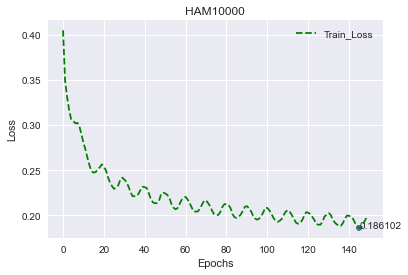

In [18]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

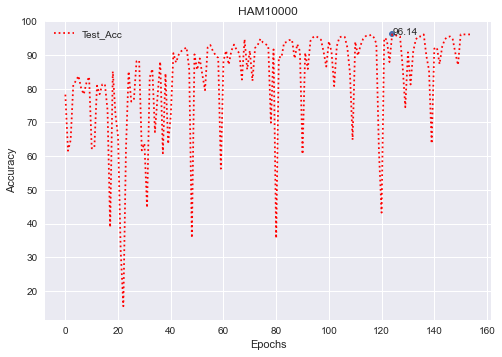

In [19]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [20]:
self_scores()

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |    0.84   | 0.913  | 0.875 |          |
|  bcc   |   0.7692  | 0.769  | 0.769 |          |
|  bkl   |   0.9464  | 0.803  | 0.869 |          |
|   df   |   0.7143  | 0.833  | 0.769 |          |
|  mel   |   0.9062  | 0.853  | 0.879 |          |
|   nv   |   0.9792  | 0.992  | 0.986 |          |
|  vasc  |    1.0    |  1.0   |  1.0  |          |
| Total: |           |        |       |  0.9614  |
+--------+-----------+--------+-------+----------+


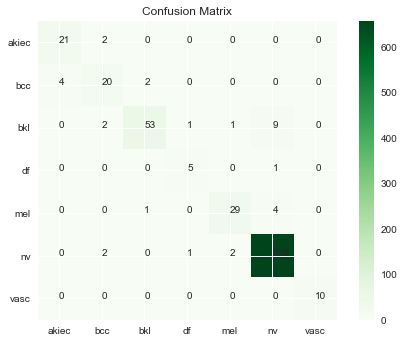

In [21]:
confusion_matrix(evl_result)

In [22]:
# #save
s1 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s1)
s2 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s2)

In [23]:
torch.cuda.memory.empty_cache()